# Cross-Sections

UXarray allows for cross-sections to be performed along arbitrary great-circle arcs (GCAs) and lines of constant latitude or longitude.

This enables analysis of workflows such as Vertical Cross-Sections when vertical dimensions (i.e., levels) are present, temporal visualizations (e.g., Hovmöller diagram), and even visualizations of arbitrary dimensions along GCAs or constant lat/lon lines.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import uxarray as ux

## Overview

Cross-sections can be performed by using the `.cross_section` method on a `ux.UxDataArray`. The original data variable is sampled along `steps` number of evenly spaced points, with the result stored as a `xr.DataArray`, since there is no longer any grid information associated with the sampled result.

```{note}
The `cross_section.bounding_box`, `cross_section.bounding_circle` and `cross_section.nearest_neighbor` methods will be deprecated in a future release, as they are now housed under the `subset` accessor.
```

Let's open up our data and define a small helper function for labeling the sampled coordinates.

In [2]:
def set_lon_lat_xticks(ax, cross_section, n_ticks=6):
    """Utility function to draw stacked lat/lon points along the sampled cross-section"""
    da = cross_section

    N = da.sizes["steps"]
    tick_pos = np.linspace(0, N - 1, n_ticks, dtype=int)
    lons = da["lon"].values[tick_pos]
    lats = da["lat"].values[tick_pos]

    tick_labels = []
    for lon, lat in zip(lons, lats):
        lon_dir = "E" if lon >= 0 else "W"
        lat_dir = "N" if lat >= 0 else "S"
        tick_labels.append(f"{abs(lon):.2f}°{lon_dir}\n{abs(lat):.2f}°{lat_dir}")

    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)

    ax.set_xlabel("Longitude\nLatitude")
    plt.tight_layout()

    return fig, ax

In [3]:
grid_path = "../../test/meshfiles/scrip/ne30pg2/grid.nc"
data_path = "../../test/meshfiles/scrip/ne30pg2/data.nc"

uxds = ux.open_dataset(grid_path, data_path)
uxds["RELHUM"]

<xarray.UxDataArray 'RELHUM' (lev: 72, n_face: 21600)> Size: 6MB
[1555200 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 576B 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
    time     object 8B ...
Dimensions without coordinates: n_face
Attributes:
    mdims:          1
    units:          percent
    long_name:      Relative humidity
    standard_name:  relative_humidity
    cell_methods:   time: mean

## Arbitrary Great Circle Arc (GCA)

A cross‑section can be performed between two **arbitrary** (lon,lat) points, which will form a geodesic arc.

In [4]:
start_point = (-45, -45)
end_point = (45, 45)

cross_section_gca = uxds["RELHUM"].cross_section(
    start=start_point, end=end_point, steps=100
)

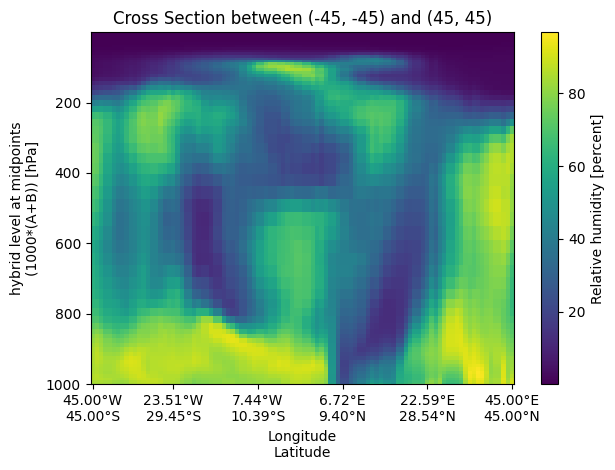

In [5]:
fig, ax = plt.subplots()
cross_section_gca.plot(ax=ax)

set_lon_lat_xticks(ax, cross_section_gca)
ax.set_title(f"Cross Section between {start_point} and {end_point}")
ax.invert_yaxis()

## Constant Latitude

A constant‐latitude cross‐section samples data along a horizontal line at a fixed latitude.


In [6]:
lat = 45
cross_section_const_lat = uxds["RELHUM"].cross_section(lat=lat, steps=100)

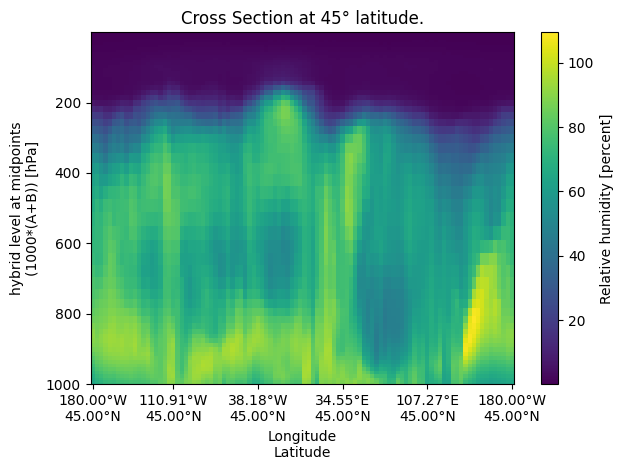

In [7]:
fig, ax = plt.subplots()
cross_section_const_lat.plot(ax=ax)

set_lon_lat_xticks(ax, cross_section_const_lat)
ax.set_title(f"Cross Section at {lat}° latitude.")
ax.invert_yaxis()

## Constant Longitude

A constant‐longitude cross‐section samples data along a vertical line at a fixed longitude

In [8]:
lon = 0
cross_section_const_lon = uxds["RELHUM"].cross_section(lon=lon, steps=100)

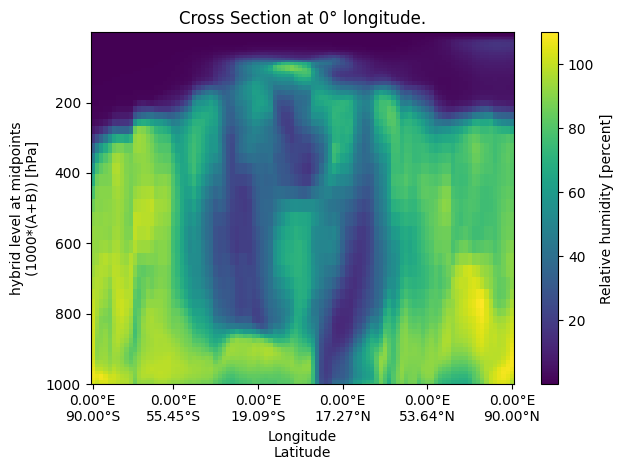

In [9]:
fig, ax = plt.subplots()
cross_section_const_lon.plot(ax=ax)

set_lon_lat_xticks(ax, cross_section_const_lon)
ax.set_title(f"Cross Section at {lon}° longitude.")
ax.invert_yaxis()

## Cumulative Integration Along the Arc

Cross-section outputs are plain `xarray.DataArray` objects, so you can call xarray utilities like `cumulative_integrate` directly. In the example below we attach a normalized `distance` coordinate along the great-circle arc and compute the cumulative integral of relative humidity along that path. Swap in actual great-circle distances if you want physical units.


Text(0, 0.5, 'Cumulative RELHUM')

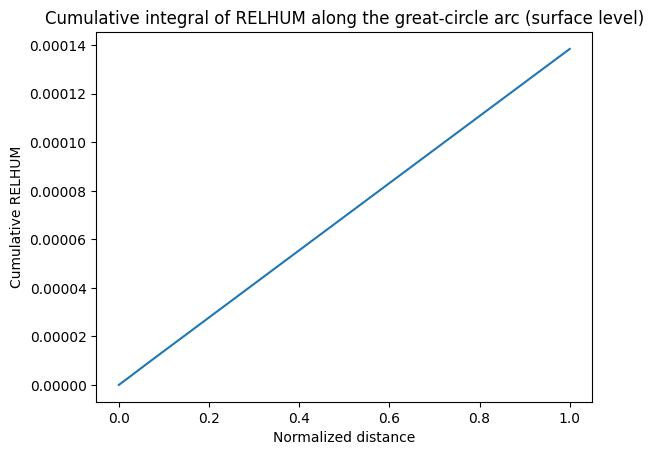

In [10]:
normalized_distance = np.linspace(0.0, 1.0, cross_section_gca.sizes["steps"])
cross_section_gca_distance = cross_section_gca.assign_coords(
    distance=("steps", normalized_distance)
)

cumulative_relhum = cross_section_gca_distance.cumulative_integrate(coord="distance")

cumulative_relhum.isel(lev=0).plot(x="distance")
plt.title("Cumulative integral of RELHUM along the great-circle arc (surface level)")
plt.xlabel("Normalized distance")
plt.ylabel("Cumulative RELHUM")

## Cumulative Integration on Other UxDataArrays

You can also call `cumulative_integrate` on any `UxDataArray` (not just cross-section outputs). Because `UxDataArray` subclasses `xarray.DataArray`, the cumulative result keeps the `uxgrid` attribute intact.


In [11]:
import uxarray as ux

uxds = ux.open_dataset(
    "../../test/meshfiles/ugrid/outCSne30/outCSne30.ug",
    "../../test/meshfiles/ugrid/outCSne30/outCSne30_sel_timeseries.nc",
)
da = uxds["psi"]

cumulative = da.cumulative_integrate(coord="time", datetime_unit="h")

# uxgrid is preserved on the cumulative result
cumulative.uxgrid is da.uxgrid

True

In [12]:
cumulative

<xarray.UxDataArray 'psi' (time: 6, n_face: 5400)> Size: 259kB
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.5       ,   0.50999999,   0.51999998, ...,  54.47000122,
         54.47999954,  54.49000168],
       [  2.        ,   2.01999998,   2.03999996, ..., 109.94000244,
        109.95999908, 109.98000336],
       [  4.5       ,   4.52999997,   4.55999994, ..., 166.41000366,
        166.43999863, 166.47000504],
       [  8.        ,   8.0400002 ,   8.07999992, ..., 223.88000488,
        223.91999817, 223.96000671],
       [ 12.5       ,  12.55000043,  12.5999999 , ..., 282.3500061 ,
        282.39999771, 282.45000839]], shape=(6, 5400))
Coordinates:
  * time     (time) datetime64[ns] 48B 2018-04-28 ... 2018-04-28T05:00:00
Dimensions without coordinates: n_face

The `psi` variable in `outCSne30` has dimensions `time: 6, n_face: 5400`, representing six time steps across 5,400 faces. To visualize the cumulative field over all faces at a single time step, slice by time and use the UxDataArray plot accessor (polygon shading).

In [21]:
time_index = 2
cumulative_time0 = cumulative.isel(time=time_index, drop=True)

cumulative_time0.plot(rasterize=True, cmap="viridis")

:Image   [x,y]   (x_y psi)